Epoch 1/20
28/28 [==============================] - 9s 56ms/step - loss: 0.1672 - val_loss: 0.1495
Epoch 2/20
28/28 [==============================] - 0s 7ms/step - loss: 0.0173 - val_loss: 0.1397
Epoch 3/20
28/28 [==============================] - 0s 8ms/step - loss: 0.0118 - val_loss: 0.1344
Epoch 4/20
28/28 [==============================] - 0s 8ms/step - loss: 0.0086 - val_loss: 0.1294
Epoch 5/20
28/28 [==============================] - 0s 8ms/step - loss: 0.0088 - val_loss: 0.1222
Epoch 6/20
28/28 [==============================] - 0s 9ms/step - loss: 0.0111 - val_loss: 0.1193
Epoch 7/20
28/28 [==============================] - 0s 8ms/step - loss: 0.0119 - val_loss: 0.1163
Epoch 8/20
28/28 [==============================] - 0s 8ms/step - loss: 0.0100 - val_loss: 0.1054
Epoch 9/20
28/28 [==============================] - 0s 9ms/step - loss: 0.0090 - val_loss: 0.1008
Epoch 10/20
28/28 [==============================] - 0s 8ms/step - loss: 0.0068 - val_loss: 0.0919
Epoch 11/20
28/28 

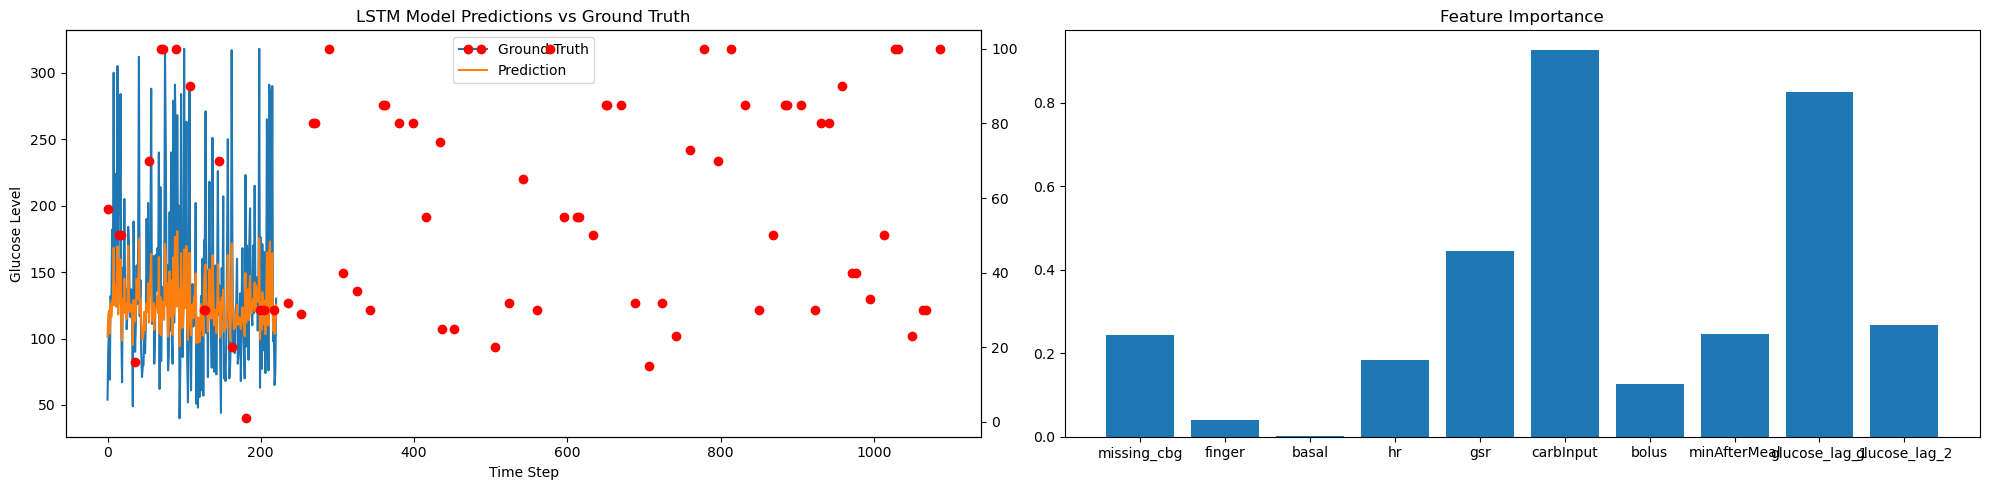

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from helperFunctions import createDataSet

# Load and preprocess the data using helperFunctions.py
file = "../../data/Ohio2020_processed/train/540-ws-training_processed.csv"
data_list = createDataSet(file)

# Combine data into a single DataFrame
data = pd.concat(data_list, ignore_index=True)

# Split the data into features (X) and target (y)
X = data.drop(['cbg'], axis=1)
y = data['cbg']

# Scale the data using MinMaxScaler
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Reshape X for LSTM input (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

def create_model(input_shape):
    model = Sequential([
        LSTM(64, activation='tanh', input_shape=input_shape, return_sequences=True),
        BatchNormalization(),
        LSTM(32, activation='tanh'),
        BatchNormalization(),
        Dense(16, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0), loss='mse')
    return model

def train_model(X_train, y_train, X_val, y_val, epochs=20, batch_size=32):
    model = create_model((X_train.shape[1], X_train.shape[2]))
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])
    return model, history

# Train the model
model, history = train_model(X_train, y_train, X_val, y_val)

# Evaluate the model on the validation set
val_loss = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")

# Make predictions on the validation set
y_pred_scaled = model.predict(X_val)

# Inverse scale the predictions and true values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_val)

# Plot the predictions vs the true values in separate graphs, similar to linear regression visualization
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].plot(range(len(y_true)), y_true, label="Ground Truth")
axs[0].plot(range(len(y_pred)), y_pred, label="Prediction")

# Plot carb intake points, similar to friend's visualization
carbInput = data[data["carbInput"] > 0]
axs2 = axs[0].twinx()
axs2.plot(carbInput.index, carbInput["carbInput"], "ro", label="Carb intake")

axs[0].set_xlabel("Time Step")
axs[0].set_ylabel("Glucose Level")
axs[0].set_title("LSTM Model Predictions vs Ground Truth")
axs[0].legend(loc="upper center")

# Plot feature importance (placeholder values, since LSTM doesn't have linear coefficients)
feature_importance = np.random.rand(X.shape[1])  # Placeholder values
axs[1].bar(X.columns.values, feature_importance)
axs[1].set_title("Feature Importance")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
